In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

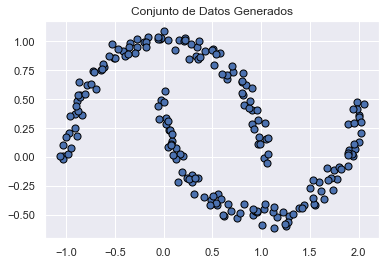

In [2]:
import numpy as np
from sklearn.datasets import make_moons

# Generar datos
X, y = make_moons(n_samples=200, noise=0.05, random_state=200)

plt.scatter(X[:, 0], X[:, 1], s=50, edgecolors='black', cmap='viridis')
plt.style.use('seaborn-darkgrid') 
plt.title('Conjunto de Datos Generados')
plt.show()


In [3]:
"""Kernel K-means"""

# Author: Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means
    
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="rbf", gamma= 1, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print ("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)



Converged at iteration 14


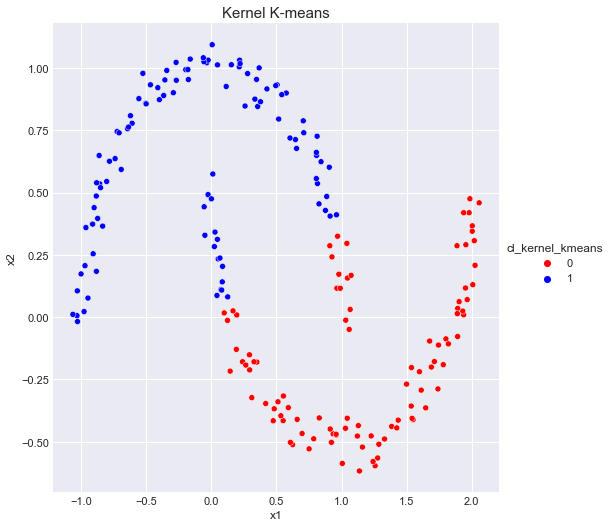

In [6]:
# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Utilizar Kernel K-means
k = 2
kernel_kmeans = KernelKMeans(n_clusters=k, random_state=0, verbose=1)
labels = kernel_kmeans.fit_predict(X_normalized)

# Asignar etiquetas de cluster
data_toy_kernel_kmeans = pd.DataFrame(X, columns=['x1', 'x2']).assign(cl_kernel_kmeans=labels)

# Graficar Kernel K-means
sns.relplot(x='x1', y='x2', data=data_toy_kernel_kmeans, hue='cl_kernel_kmeans' , palette=custom_palette, height=7, legend='brief')
plt.title("Kernel K-means", fontsize=15)
plt.show()

# K - Medoids

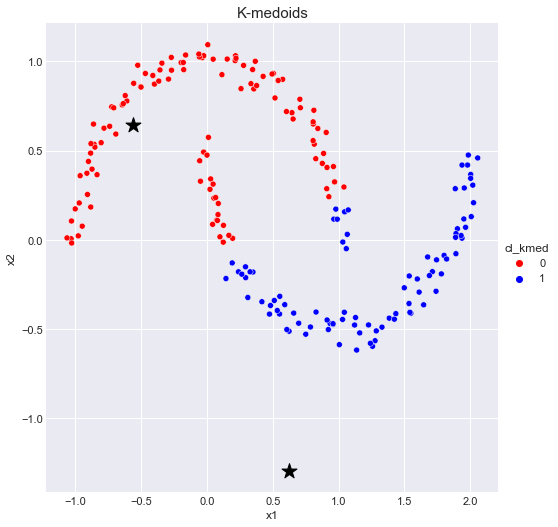

In [7]:
# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply K-medoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(X_normalized)

# Assign cluster labels to the original data
data_toy_kmed = pd.DataFrame(X, columns=['x1', 'x2']).assign(cl_kmed=kmedoids.labels_)

# Plot the results
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_kmed, hue='cl_kmed', height=7, palette=custom_palette, legend='brief')
plt.title("K-medoids", fontsize=15)
plt.scatter(
    kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.show()



# Fuzzy K - Means

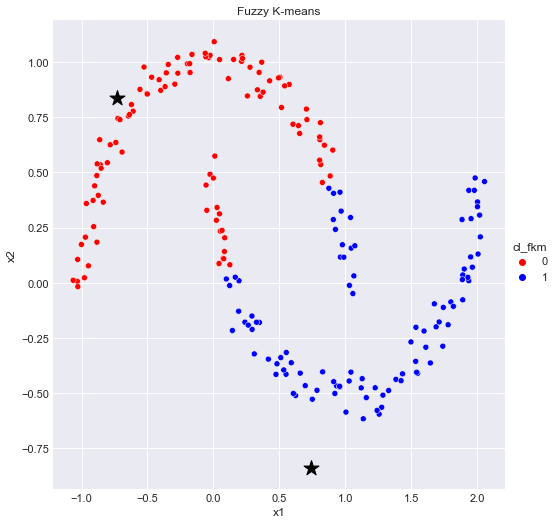

In [5]:
from skfuzzy.cluster import cmeans
from sklearn.preprocessing import StandardScaler

# Aplicar Fuzzy K means
n_clusters = 2
m = 2
cntr, fuzzy_labels, _, _, _, _, _ = cmeans(X_normalized.T, n_clusters, m, error=0.005, maxiter=1000, init=None)

# Asignar cluster
data_toy_fkm = pd.DataFrame(X, columns=['x1', 'x2']).assign(cl_fkm=np.argmax(fuzzy_labels, axis=0))

# Graficar
custom_palette = ["red", "blue"]  # Two clusters, adjust colors as needed
sns.relplot(x='x1', y='x2', data=data_toy_fkm, hue='cl_fkm', height=7, palette=custom_palette, legend='brief')
plt.scatter(
    cntr[:, 0], cntr[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.title("Fuzzy K-means")
plt.show()

# Clustering Espectral

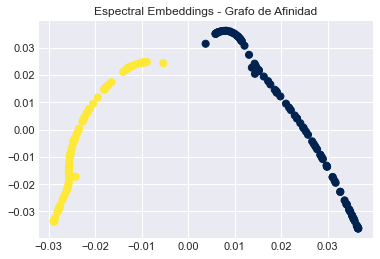

In [19]:
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler


# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Crear el grafo de afinidad utilizando Espectral Embeddings
n_neighbors = 10  # Número de vecinos para la construcción del grafo
spectral_embedding = SpectralEmbedding(n_neighbors=n_neighbors, n_components=2, random_state=0)
embedding = spectral_embedding.fit_transform(X_normalized)

# Visualizar el grafo de afinidad
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='cividis', s=50)
plt.title('Espectral Embeddings - Grafo de Afinidad')
plt.show()

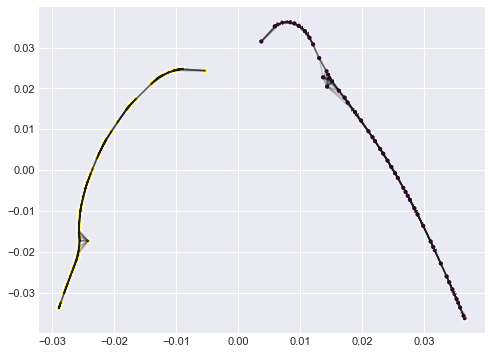

In [20]:
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Crear el grafo de afinidad utilizando Spectral Embeddings
n_neighbors = 10
spectral_embedding = SpectralEmbedding(n_neighbors=n_neighbors, n_components=2, random_state=0)
embedding = spectral_embedding.fit_transform(X_normalized)

# Encontrar vecinos más cercanos para cada punto
neighbors_model = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_model.fit(embedding)
distances, indices = neighbors_model.kneighbors(embedding)

# Visualizar el grafo de afinidad con conexiones
plt.figure(figsize=(8, 6))

# Mostrar conexiones
for i in range(embedding.shape[0]):
    for j in indices[i]:
        plt.plot([embedding[i, 0], embedding[j, 0]], [embedding[i, 1], embedding[j, 1]], 'k-', alpha=0.2)

# Mostrar puntos
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', s=30, edgecolors='w')

# Mostrar la gráfica
plt.show()


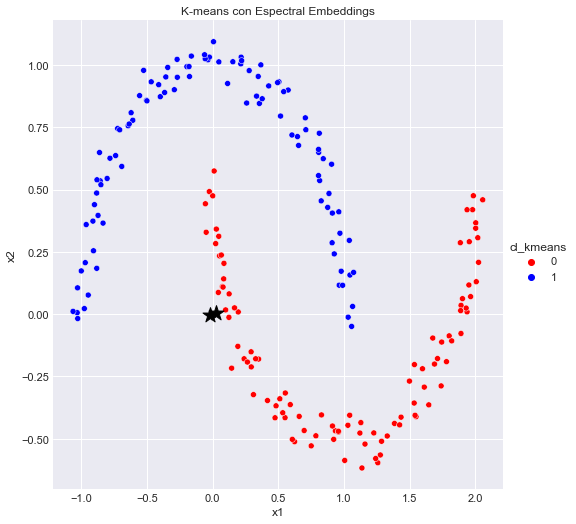

In [21]:
# Aplicar K-means al embedding obtenido
n_clusters_kmeans = 2  # Número de clusters para K-means
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0)
labels_kmeans = kmeans.fit_predict(embedding)

# Asignar etiquetas de clúster al conjunto de datos original
data_toy_se = pd.DataFrame(X, columns=['x1', 'x2']).assign(cl_kmeans=labels_kmeans)

# Visualizar los resultados
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_se, hue='cl_kmeans', height=7, palette=custom_palette, legend='brief')

# centros de clúster
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.title("K-means con Espectral Embeddings")
plt.show()


# T - SNE

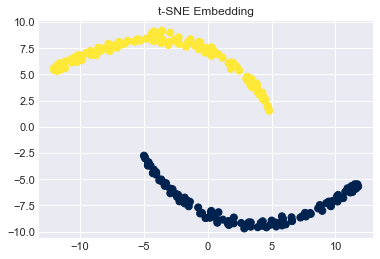

In [55]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Aplicar t-SNE para reducción de dimensionalidad
tsne = TSNE(n_components=2, random_state=0)
embedding_tsne = tsne.fit_transform(X_normalized)

# Visualizar el resultado de t-SNE
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=y, cmap='cividis', s=50)
plt.title('t-SNE Embedding')
plt.show()


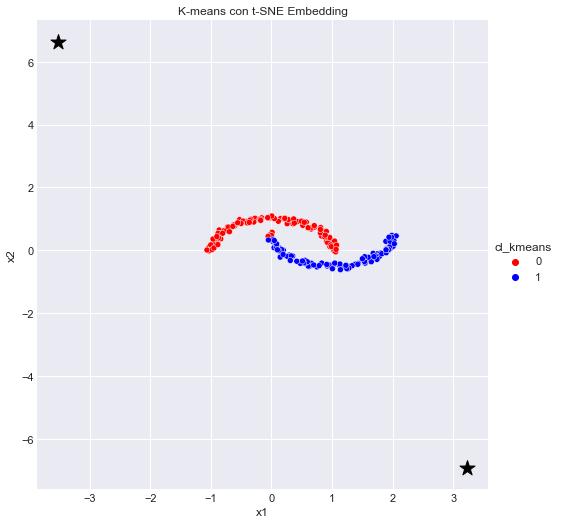

In [56]:
K = 2
kmeans_tsne = KMeans(n_clusters= K, random_state=0)
labels_kmeans_tsne = kmeans_tsne.fit_predict(embedding_tsne)

# Asignar etiquetas 
data_toy_tsne = pd.DataFrame(X, columns=['x1', 'x2']).assign(cl_kmeans=labels_kmeans_tsne)

# Visualizar K-means en el embedding t-SNE
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_tsne, hue='cl_kmeans', height=7, palette=custom_palette, legend='brief')

# Plotear los centros de clúster
plt.scatter(
    kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.title("K-means con t-SNE Embedding")
plt.show()

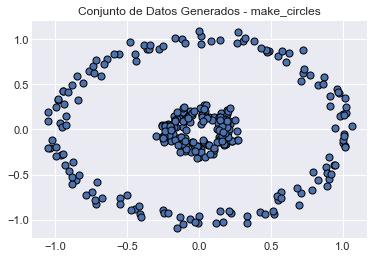

In [8]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generar datos
X_circles, y_circles = make_circles(n_samples=300, noise=0.05, random_state=200, factor=0.2)

# Visualizar los datos
plt.scatter(X_circles[:, 0], X_circles[:, 1], s=50, edgecolors='black', cmap='viridis')
plt.title('Conjunto de Datos Generados - make_circles')
plt.show()

Converged at iteration 3


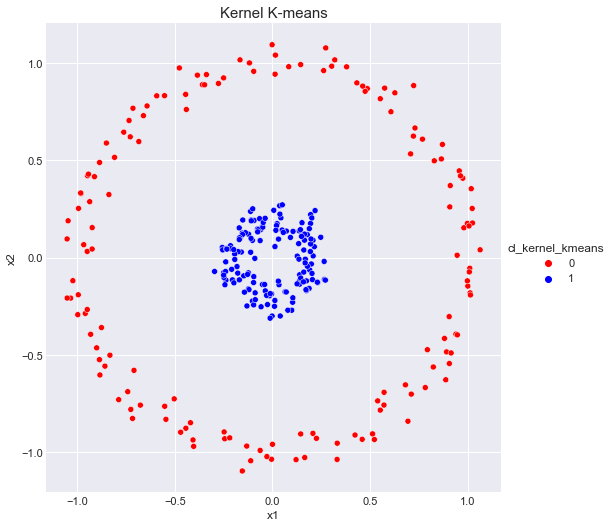

In [9]:
# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_circles)

# Utilizar Kernel K-means
k = 2
kernel_kmeans = KernelKMeans(n_clusters=k, random_state=0, verbose=1)
labels = kernel_kmeans.fit_predict(X_normalized)

# Asignar etiquetas de cluster
data_toy_kernel_kmeans = pd.DataFrame(X_circles, columns=['x1', 'x2']).assign(cl_kernel_kmeans=labels)

# Graficar Kernel K-means
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_kernel_kmeans, hue='cl_kernel_kmeans' , palette=custom_palette, height=7, legend='brief')
plt.title("Kernel K-means", fontsize=15)
plt.show()

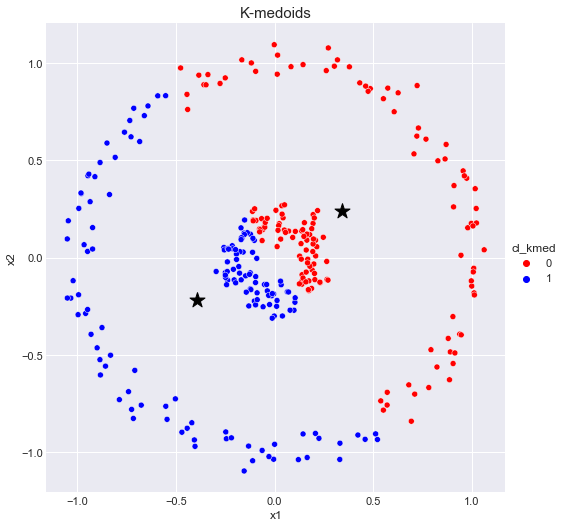

In [10]:
# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_circles)

# Apply K-medoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(X_normalized)

# Assign cluster labels to the original data
data_toy_kmed = pd.DataFrame(X_circles, columns=['x1', 'x2']).assign(cl_kmed=kmedoids.labels_)

# Plot the results
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_kmed, hue='cl_kmed', height=7, palette=custom_palette, legend='brief')
plt.title("K-medoids", fontsize=15)
plt.scatter(
    kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.show()



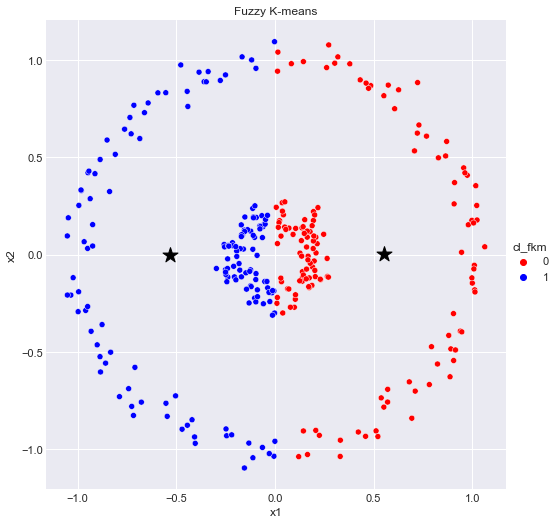

In [12]:
from skfuzzy.cluster import cmeans
from sklearn.preprocessing import StandardScaler

# Aplicar Fuzzy K means
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_circles)
n_clusters = 2
m = 2
cntr, fuzzy_labels, _, _, _, _, _ = cmeans(X_normalized.T, n_clusters, m, error=0.005, maxiter=1000, init=None)

# Asignar cluster
data_toy_fkm = pd.DataFrame(X_circles, columns=['x1', 'x2']).assign(cl_fkm=np.argmax(fuzzy_labels, axis=0))

# Graficar
custom_palette = ["red", "blue"]  # Two clusters, adjust colors as needed
sns.relplot(x='x1', y='x2', data=data_toy_fkm, hue='cl_fkm', height=7, palette=custom_palette, legend='brief')
plt.scatter(
    cntr[:, 0], cntr[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.title("Fuzzy K-means")
plt.show()

C:\Users\nmari\Documents\PYTHON\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


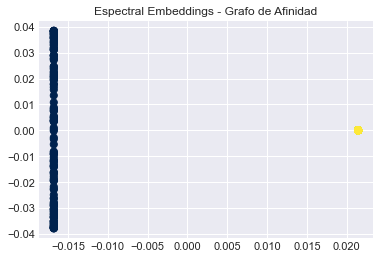

In [22]:
# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_circles)

# Crear el grafo de afinidad utilizando Espectral Embeddings
n_neighbors = 10  # Número de vecinos para la construcción del grafo
spectral_embedding = SpectralEmbedding(n_neighbors=n_neighbors, n_components=2, random_state=0)
embedding = spectral_embedding.fit_transform(X_normalized)

# Visualizar el grafo de afinidad
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_circles, cmap='cividis', s=50)
plt.title('Espectral Embeddings - Grafo de Afinidad')
plt.show()

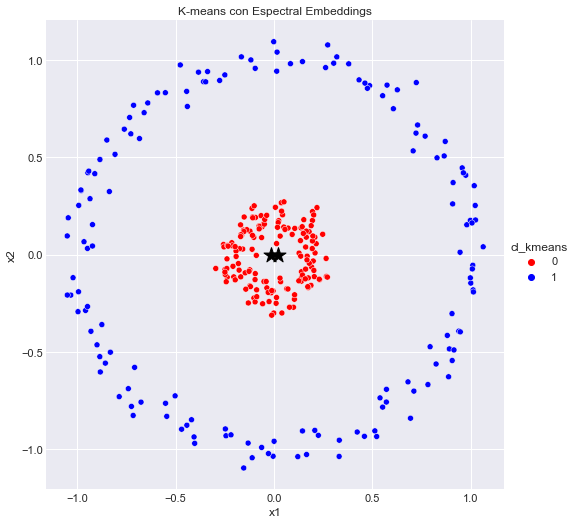

In [23]:
# Aplicar K-means al embedding obtenido
n_clusters_kmeans = 2  # Número de clusters para K-means
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0)
labels_kmeans = kmeans.fit_predict(embedding)

# Asignar etiquetas de clúster al conjunto de datos original
data_toy_se = pd.DataFrame(X_circles, columns=['x1', 'x2']).assign(cl_kmeans=labels_kmeans)

# Visualizar los resultados
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_se, hue='cl_kmeans', height=7, palette=custom_palette, legend='brief')

# centros de clúster
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.title("K-means con Espectral Embeddings")
plt.show()

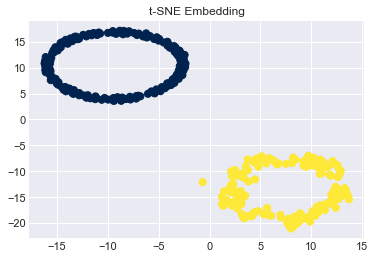

In [24]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_circles)

# Aplicar t-SNE para reducción de dimensionalidad
tsne = TSNE(n_components=2, random_state=0)
embedding_tsne = tsne.fit_transform(X_normalized)

# Visualizar el resultado de t-SNE
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=y_circles, cmap='cividis', s=50)
plt.title('t-SNE Embedding')
plt.show()


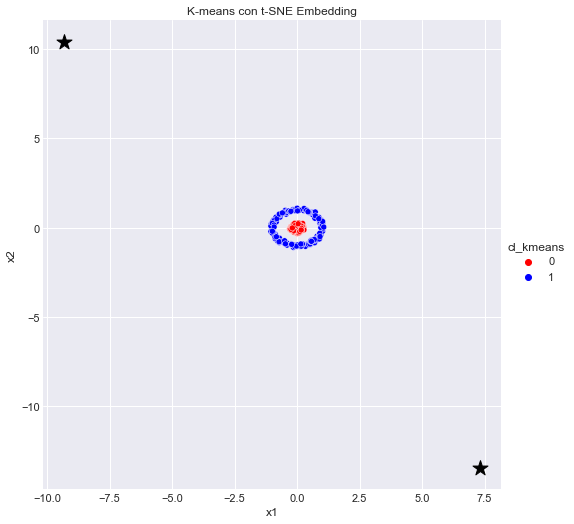

In [25]:
K = 2
kmeans_tsne = KMeans(n_clusters= K, random_state=0)
labels_kmeans_tsne = kmeans_tsne.fit_predict(embedding_tsne)

# Asignar etiquetas 
data_toy_tsne = pd.DataFrame(X_circles, columns=['x1', 'x2']).assign(cl_kmeans=labels_kmeans_tsne)

# Visualizar K-means en el embedding t-SNE
custom_palette = ["red", "blue"]
sns.relplot(x='x1', y='x2', data=data_toy_tsne, hue='cl_kmeans', height=7, palette=custom_palette, legend='brief')

# Plotear los centros de clúster
plt.scatter(
    kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)

plt.title("K-means con t-SNE Embedding")
plt.show()